# 행정구역 경계 나타내기

## import ..

In [1]:
# !pip install geopandas

In [2]:
# 지리적 데이터프레임
import geopandas as gpd

# 데이터프레임
import pandas as pd

# hadoop
from hdfs import InsecureClient

#json
import json

#folium
import folium

### 폰트 스타일 설정

In [3]:
# 폰트 스타일 설정
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 차트 스타일 설정
plt.style.use('fivethirtyeight')

# D2Coding 폰트 설정
d2coding_path = './D2Coding-Ver1.3.2-20180524.ttf' # 폰트 경로
fm.fontManager.addfont(d2coding_path)
plt.rcParams['font.family'] = 'D2Coding'

# 마이너스 부호 깨지지 않도록 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## Geopandas 사용

In [4]:
# gpd.read_file('path')
path = './dataset/Busan_Boundary/LARD_ADM_SECT_SGG_26_202405.shp'
geo_df = gpd.read_file(path)
print(geo_df[['SGG_NM', 'geometry']])

        SGG_NM                                           geometry
0     부산광역시 중구  POLYGON ((385270.012 281905.258, 385273.98 281...
1     부산광역시 서구  MULTIPOLYGON (((383830.943 274185.797, 383829....
2     부산광역시 동구  POLYGON ((386095.84 285221.702, 386124.993 285...
3    부산광역시 영도구  MULTIPOLYGON (((391014.284 273274.471, 391015....
4   부산광역시 부산진구  POLYGON ((386164.468 291137.31, 386211.637 291...
5    부산광역시 동래구  POLYGON ((389159.807 294173.291, 389179.338 29...
6     부산광역시 남구  MULTIPOLYGON (((392090.519 278501.301, 392062....
7     부산광역시 북구  POLYGON ((385242.484 299557.181, 385384.864 29...
8   부산광역시 해운대구  MULTIPOLYGON (((395911.045 285949.703, 395912....
9    부산광역시 사하구  MULTIPOLYGON (((378483.109 256052.545, 378483....
10   부산광역시 금정구  POLYGON ((392074.04 302850.357, 392105.01 3028...
11   부산광역시 강서구  MULTIPOLYGON (((366897.494 267329.265, 366897....
12   부산광역시 연제구  POLYGON ((389265.711 291202.229, 389274.941 29...
13   부산광역시 수영구  MULTIPOLYGON (((393538.512 286075.579, 393537....
14   부산광역시

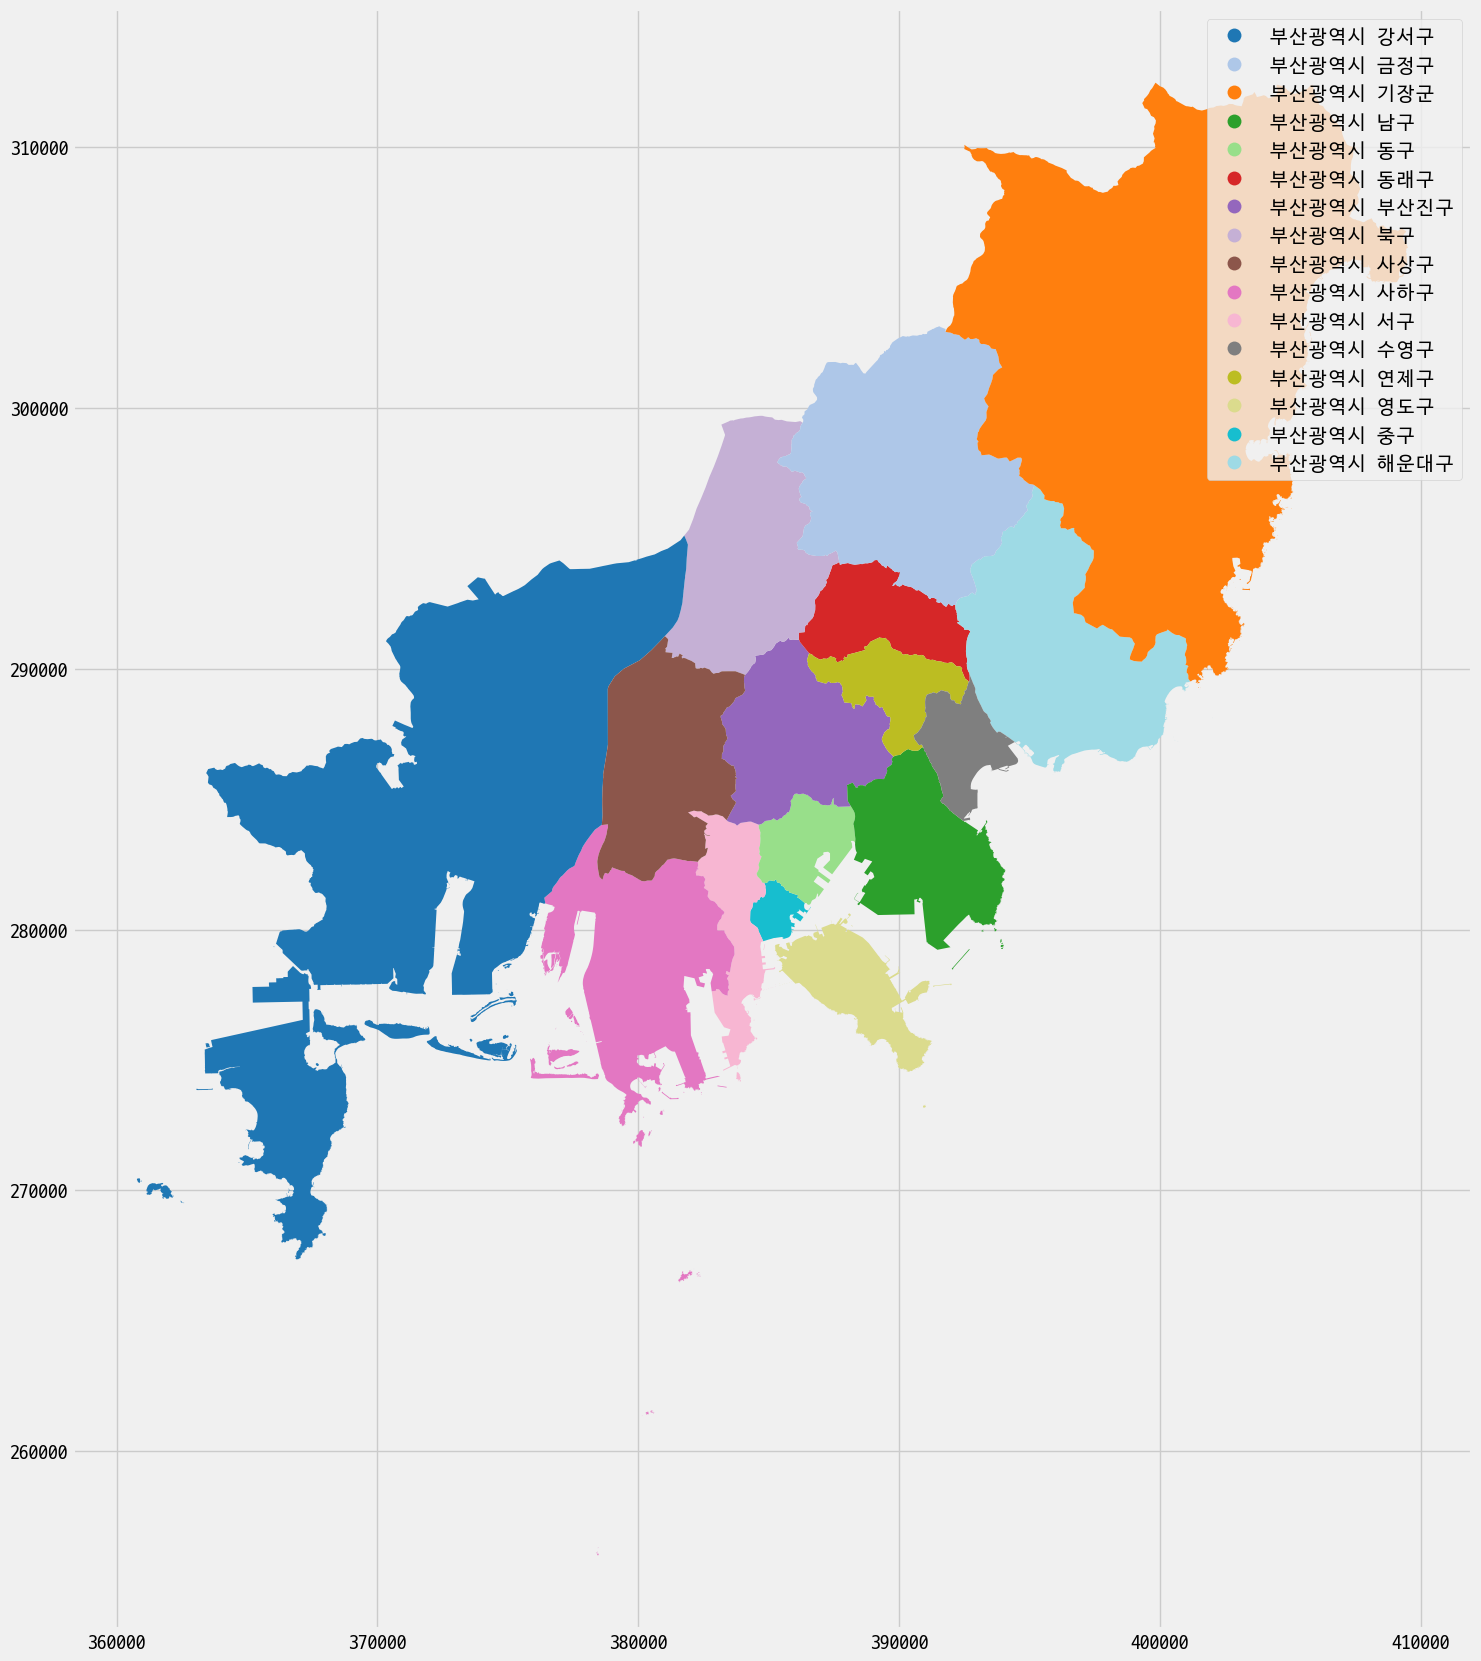

In [5]:
# 컬러맵 설정
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
geo_df.plot(column='SGG_NM', ax=ax, legend=True, cmap='tab20')

plt.show()

### 부산광역시 인구동테 현황으로 스타벅스 지점과의 연관성 찾기

In [9]:
hdfs = InsecureClient('http://bdata.iptime.org:9999',user='hadoop')

In [10]:
read_path = '/user/hadoop/dataset/부산광역시주민등록인구통계_20231231.csv'
with hdfs.read(read_path,encoding='euc-kr') as reader:
    data = pd.read_csv(reader)

In [11]:
ingu_data = data[['구군','인구수(명)']] # 원하는 컬럼 데이터만 가져오기
ingu_data = ingu_data.sort_values(by='인구수(명)', ascending=False) # 인구수 순으로 정렬

ingu_data = ingu_data.rename(columns={'인구수(명)': '인구수'}) # 데이터프레임 통합 전에 이름을 변경

In [12]:
ingu_data.head(8)

,구군,인구수
8,해운대구,385618
4,부산진구,362505
9,사하구,302947
7,북구,275773
5,동래구,272178
6,남구,260899
10,금정구,220286
14,사상구,208794


In [ ]:
read_path2 = '/user/hadoop/dataset/starbucks_20241229115540.csv'
with hdfs.read(read_path2) as reader:
    star = pd.read_csv(reader)

# star

In [ ]:
sta_data = star.copy()
sta_data.columns = ['no.', 'name', 'lat', 'lon', 'addr', 'type'] # 컬럼명 바꾸기
sta_data['addr'] = sta_data['addr'].str.replace('1522-3232', '') # 전화번호? 지우기
sta_data.head(5)

In [ ]:
# del sta_data['no.']
# sta_data.head(5)

In [ ]:
# addr_list = sta_data['addr']
# gu = []
# for a in addr_list:
#     gu.append(a.split(' ')[1])
# sta_data['구군'] = gu
# sta_data.head(7)

sta_data['구군'] = [a.split(' ')[1] for a in sta_data['addr']] # 리스트 컴프리헨션
sta_data.head(3)

In [ ]:
sta_count = sta_data.groupby('구군')['구군'].count().reset_index(name='스벅수') # 구군별 스타벅스 지점 수
print(sta_count)

In [ ]:
total = pd.merge(ingu_data, sta_count, on='구군', how='left')
print(total)

In [ ]:
read_path3 = '/user/hadoop/dataset/산업대분류__읍·면·동별_사업체수__종사자수_20250108114913.csv'
with hdfs.read(read_path3, encoding='euc-kr') as reader:
    biz_data = pd.read_csv(reader)
biz_data.columns

In [ ]:
biz_data = biz_data.rename(
    columns={
        '읍·면·동별(1)':'구군', 
        '사업체수 (개)':'사업체수', 
        '종사자수 (명)':'종사자수'
    }
)
biz_data = biz_data[['구군', '사업체수', '종사자수']]
biz_data = biz_data.sort_values(by='종사자수', ascending=False)
biz_data

In [ ]:
_worker = pd.merge(total, biz_data, on='구군', how='left')
_worker

In [ ]:
# 하둡에서 가져올 때(실패):
# read_path4 = '/user/hadoop/dataset/LARD_ADM_SECT_SGG_26_202405.shp'
# with hdfs.read(read_path4) as reader:

In [ ]:
# 로컬에서 직접 읽기:
geo_path = './dataset/Busan_Boundary/LARD_ADM_SECT_SGG_26_202405.shp'
geo_data = gpd.read_file(geo_path)
geo_data = geo_data.to_crs(epsg=4326)
geo_data

In [ ]:
coordinates=[]
for idx, row in geo_data.iterrows():
    latitude = row.geometry.centroid.y
    longitude = row.geometry.centroid.x
    coordinates.append([row['SGG_NM'],latitude, longitude])
    print(f"{row['SGG_NM'][6:]}의 중심점 좌표: 위도 {latitude}, 경도 {longitude}")

_geo = pd.DataFrame(coordinates)
_geo.columns = ['구군', '위도', '경도']
_geo['구군'] = _geo['구군'].str[6:]
_geo

In [ ]:
_content = pd.merge(_worker, _geo, on='구군', how='left')
_content

### geopandas -> json

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# _content.plot(column='구군', ax=ax, legend=True, cmap='tab20')

# plt.show()

In [ ]:
gdf = gpd.read_file('./dataset/Busan_Boundary/LARD_ADM_SECT_SGG_26_202405.shp')
gdf = gdf.to_crs(epsg=4326)

gdf.head(3)

In [ ]:
#GeoJson 파일
gjson = gdf.to_json()
# json 파싱
json_data = json.loads(gjson)
ep = json_data['features'][0]['geometry']['coordinates'][0]
print(ep)
# print(json_data.keys())
_latlons = pd.DataFrame(ep)
_latlons.columns = ['위도', '경도']
_latlons

In [ ]:
loc_mean = _content[['위도', '경도']].mean()
print(loc_mean)
print(list(loc_mean))

In [ ]:
sta_mean = _content['스벅수'].mean()
print(sta_mean)

## Folium

In [ ]:
def f_style(feature):
    return {'opacity': 0.7, 'weight': 1.5, 'color': 'red', 'fillOpacity': 0, 'dashArray': '5,5'}

In [ ]:
import math

In [ ]:
_map = folium.Map(
    location=list(loc_mean),
    # tiles 옵션의 CartoDB 종류: Positron, Dark Matter, Voyager
    tiles='CartoDB Voyager',
    zoom_start=10
)
folium.GeoJson(json_data, style_function=f_style).add_to(_map)

for i in _content.index:
    lat = float(_content.loc[i, '위도'])
    lon = float(_content.loc[i, '경도'])
    cnt = int(_content.loc[i, '스벅수'])
    if abs(cnt - sta_mean) <= 1:
        fill_color = 'green'
    elif cnt >= sta_mean:
        fill_color = 'red'
    else:
        fill_color = 'blue'
    folium.CircleMarker(
        location=[lat, lon],
        color='yellow',
        fill_color=fill_color,
        fill_opacity=0.7,
        weight=2,
        radius=math.log2(cnt)*2,
    ).add_to(_map)
# _map.save('re/positron.html')
_map

In [ ]:
print(type(gdf['geometry'][0]))

In [ ]:
print(gjson[:200])

In [ ]:
geojson_data = json.loads(gjson)
for f in geojson_data['features']:
    # print(f['properties']['SGG_NM'])
    f['properties']['SGG_NM'] = f['properties']['SGG_NM'][6:] # '부산광역시 영도구'를 '영도구'로 바꾸기
# print(geojson_data['features'][0])
# folium.Map
_map2 = folium.Map(
    location=list(loc_mean),
    # tiles 옵션의 CartoDB 종류: Positron, Dark Matter, Voyager
    tiles='CartoDB Dark Matter',
    zoom_start=10
)
# folium.Choropleth
folium.Choropleth(
    geo_data=geojson_data,
    data=_content,
    columns=['구군', '스벅수'],
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.SGG_NM',
    legend_name='스벅수'
    
).add_to(_map2)
# _map2.save('re/starbucks.html')
_map2

In [ ]:
_map3 = folium.Map(
    location=list(loc_mean),
    # tiles 옵션의 CartoDB 종류: Positron, Dark Matter, Voyager
    tiles='CartoDB Dark Matter',
    zoom_start=10
)

_res = _content.copy()

folium.Choropleth(
    geo_data=geojson_data,
    data=_res,
    columns=['구군', '인구수'],
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.SGG_NM',
    legend_name='인구수'
    
).add_to(_map3)
# _map3.save('re/population.html')
_map3

In [ ]:
_map4 = folium.Map(
    location=list(loc_mean),
    tiles='CartoDB Dark Matter',
    zoom_start=10
)

folium.Choropleth(
    geo_data=geojson_data,
    data=_res,
    columns=['구군', '사업체수'],
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.SGG_NM',
    legend_name='사업체수'
).add_to(_map4)
# _map4.save('re/companies.html')
_map4

In [ ]:
_map5 = folium.Map(
    location=list(loc_mean),
    tiles='CartoDB Dark Matter',
    zoom_start=10
)

folium.Choropleth(
    geo_data=geojson_data,
    data=_res,
    columns=['구군', '종사자수'],
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.SGG_NM',
    legend_name='종사자수'
).add_to(_map5)
# _map5.save('re/workers.html')
_map5